In [403]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
import umap
import joblib
import json
import os
import cv2
from tensorflow.keras.models import load_model
import ipywidgets as widgets
from IPython.display import display

In [404]:
ds_train = tfds.load('emnist/balanced', split='train', as_supervised=True)
ds_test = tfds.load('emnist/balanced', split='test', as_supervised=True)

def prep(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.transpose(image)
    return tf.reshape(image, [-1]), label

ds_train = ds_train.map(prep).batch(256).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(prep).batch(256).prefetch(tf.data.AUTOTUNE)

X, y = [], []
for batch in tfds.as_numpy(ds_train.concatenate(ds_test)):
    X.append(batch[0])
    y.append(batch[1])
X = np.vstack(X)
y = np.concatenate(y)

In [413]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(500, activation='relu')(input_img)
encoded = layers.Dense(500, activation='relu')(encoded)
encoded = layers.Dense(2000, activation='relu')(encoded)
encoded = layers.Dense(64, activation=None)(encoded)

decoded = layers.Dense(2000, activation='relu')(encoded)
decoded = layers.Dense(500, activation='relu')(decoded)
decoded = layers.Dense(500, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
autoencoder.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')

In [414]:
print(X.shape)

(131600, 784)


In [415]:
autoencoder.fit(X, X, epochs=20, batch_size=256, shuffle=True)

Epoch 1/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - loss: 0.0661
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - loss: 0.0146
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - loss: 0.0099
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - loss: 0.0080
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 31s 59ms/step - loss: 0.0071
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 31s 59ms/step - loss: 0.0064
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - loss: 0.0058
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step - loss: 0.0054
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - loss: 0.0051
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - loss: 0.0049
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - loss: 0.0047
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - loss: 0.0045
Epoch 13/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - loss: 0.0044
Epoch 14/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - loss: 0.0042
Epoch 15/20
515/515 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


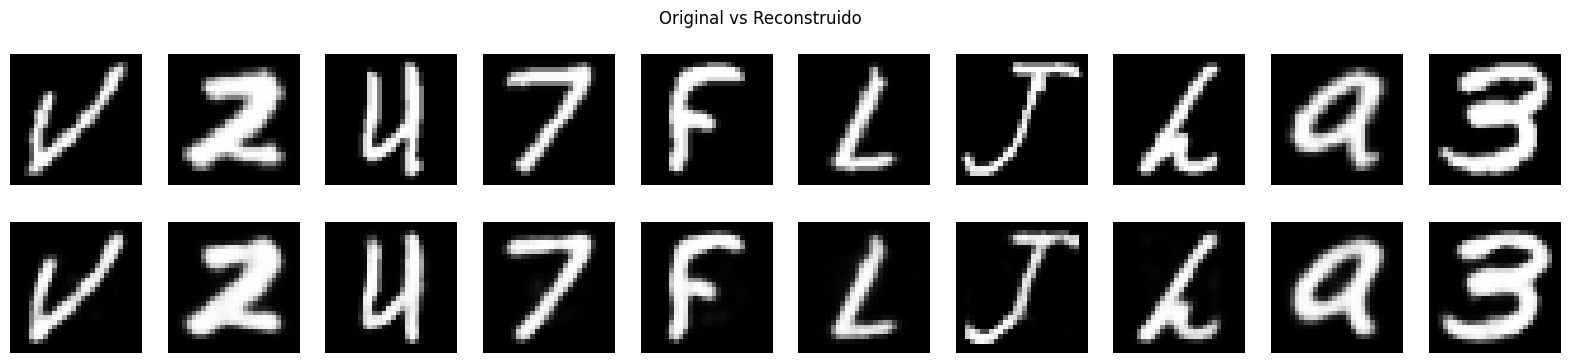

In [417]:
def plot_reconstructions(X):
    x_sample = X[:10]
    x_recon = autoencoder.predict(x_sample)
    x_sample = x_sample.reshape(-1, 28, 28)
    x_recon = x_recon.reshape(-1, 28, 28)
    plt.figure(figsize=(20, 4))
    for i in range(10):
        plt.subplot(2, 10, i+1)
        plt.imshow(x_sample[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 10, i+11)
        plt.imshow(x_recon[i], cmap='gray')
        plt.axis('off')
    plt.suptitle("Original vs Reconstruido")
    plt.show()

plot_reconstructions(X)

In [418]:
Z = encoder.predict(X)
Z_norm = StandardScaler().fit_transform(Z)
n_clases = len(np.unique(y))
kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=42).fit(Z_norm)
labels_km = kmeans.labels_

4113/4113 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


In [419]:
n_clases

47

In [420]:
ari = adjusted_rand_score(y, labels_km)
ami = adjusted_mutual_info_score(y, labels_km)
print(f"\nEvaluación Clustering → ARI: {ari:.4f} | AMI: {ami:.4f}\n")


Evaluación Clustering → ARI: 0.2024 | AMI: 0.4376



c:\Users\A03427\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


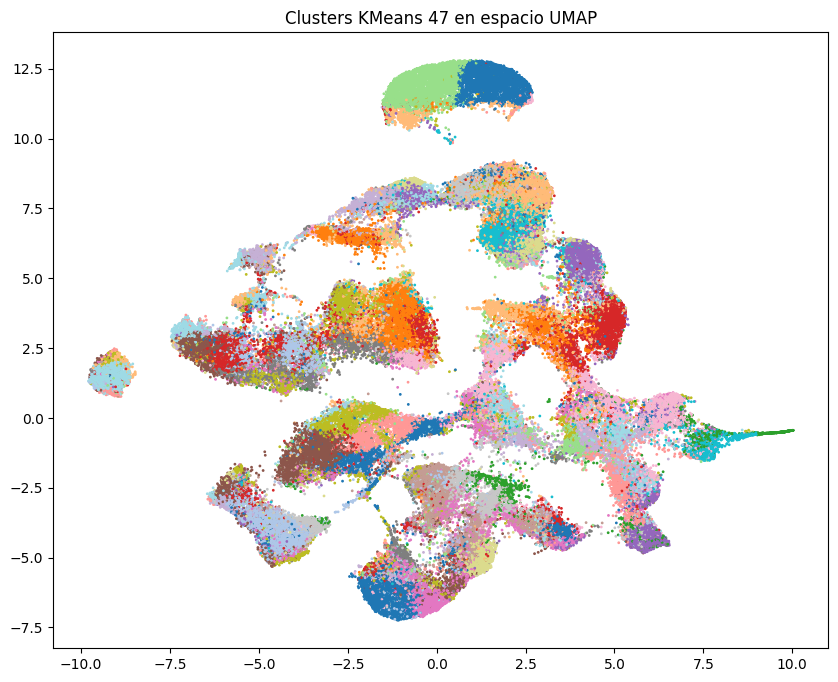

In [416]:
reduced = umap.UMAP(n_components=2, random_state=42).fit_transform(Z_norm)
plt.figure(figsize=(10, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels_km, cmap='tab20', s=1)
plt.title('Clusters KMeans ' + str(n_clases) + ' en espacio UMAP')
plt.show()

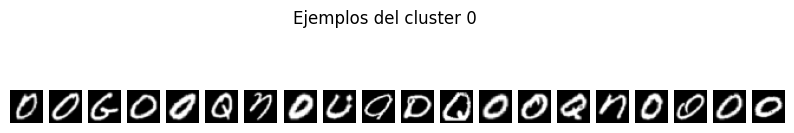

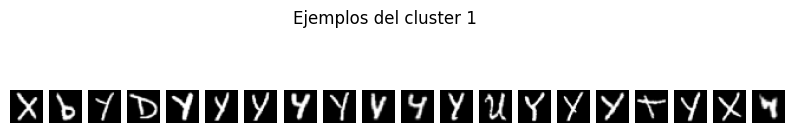

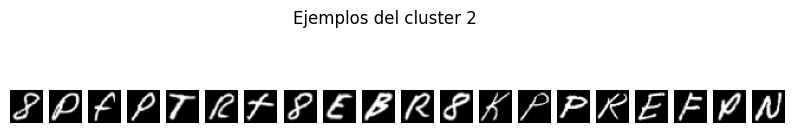

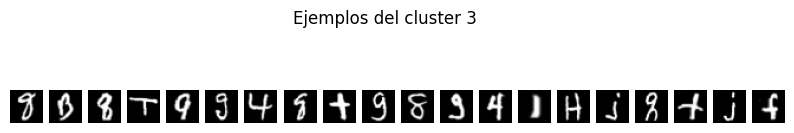

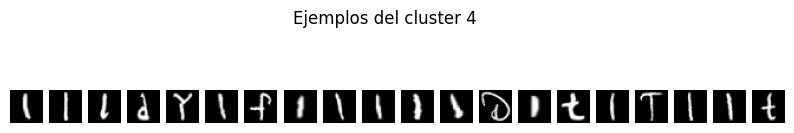

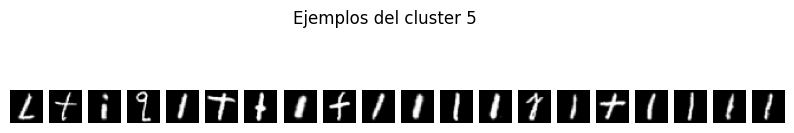

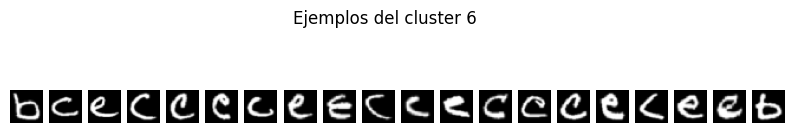

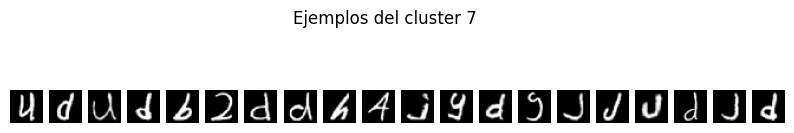

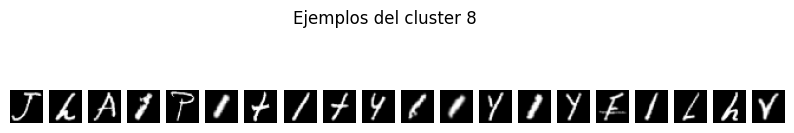

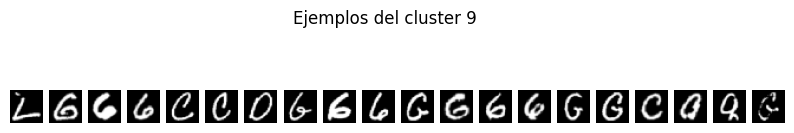

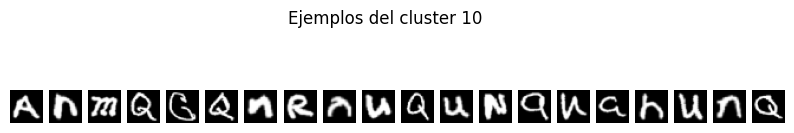

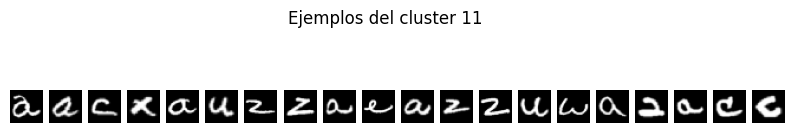

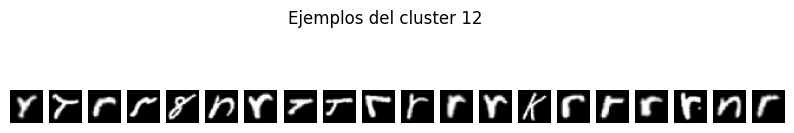

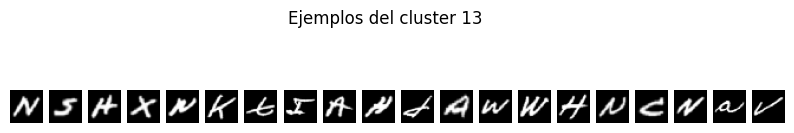

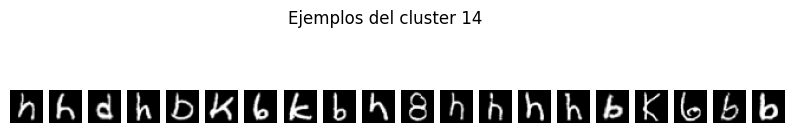

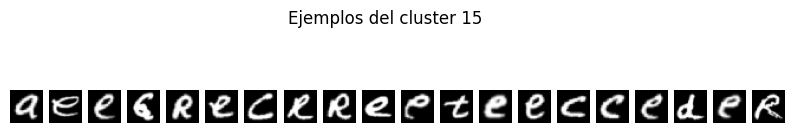

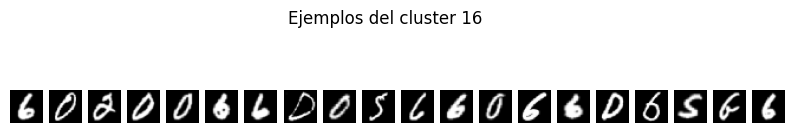

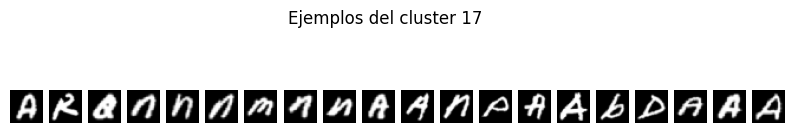

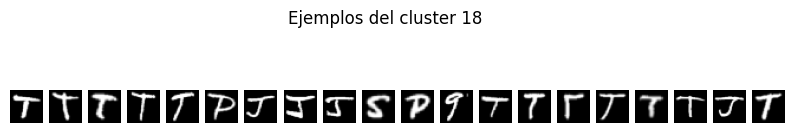

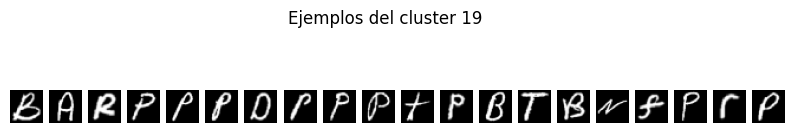

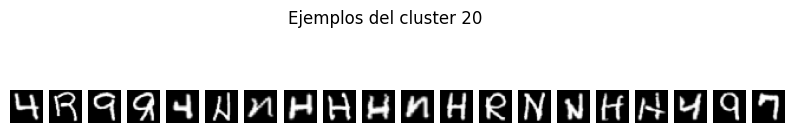

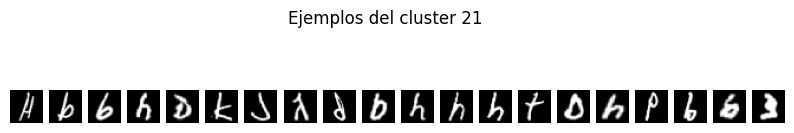

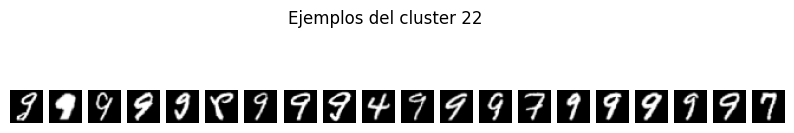

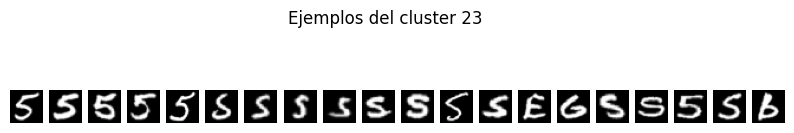

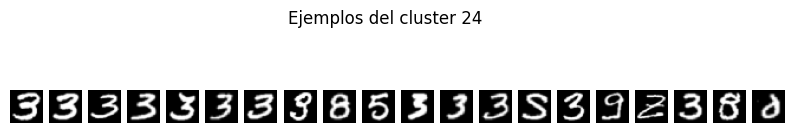

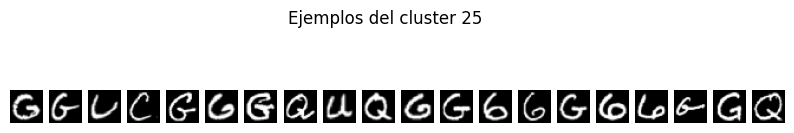

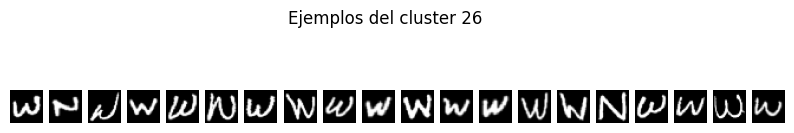

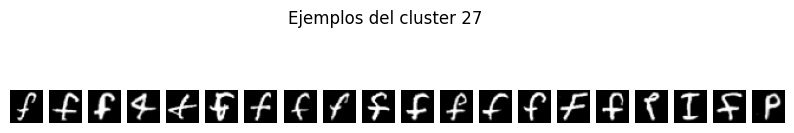

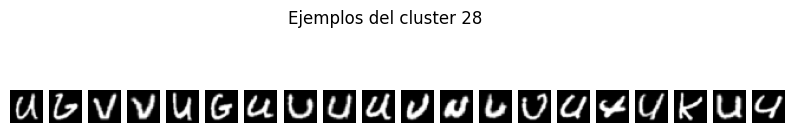

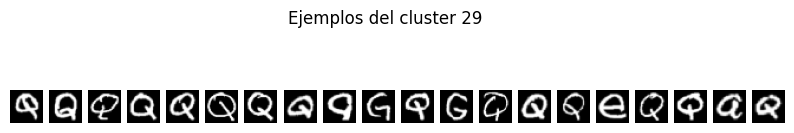

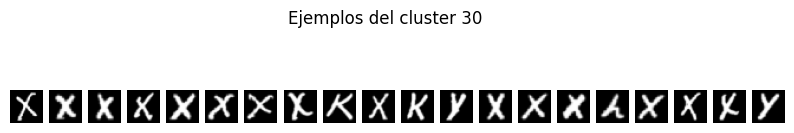

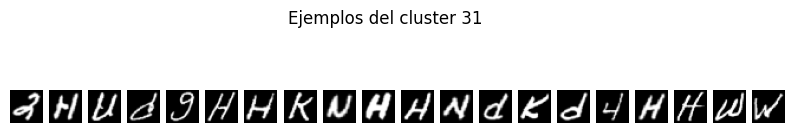

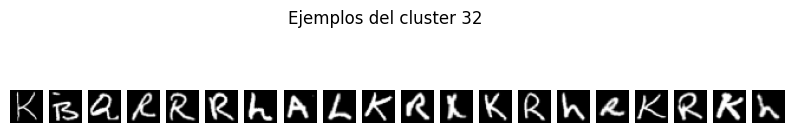

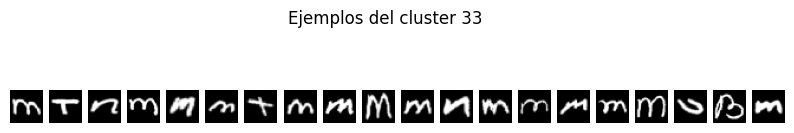

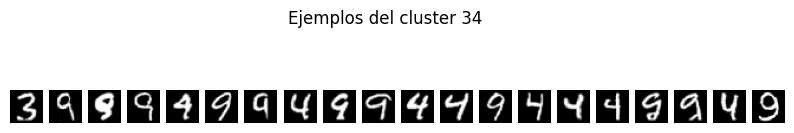

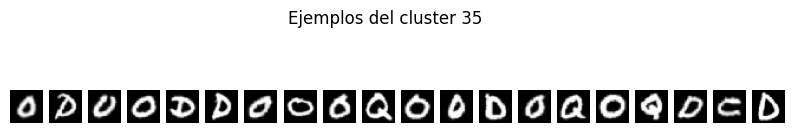

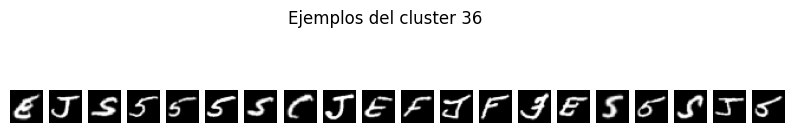

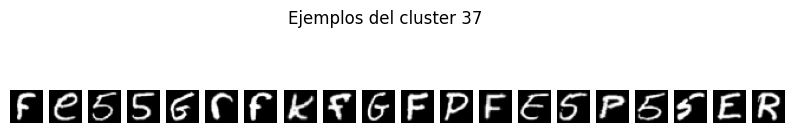

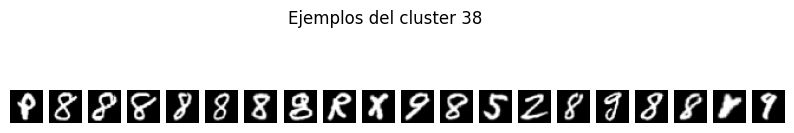

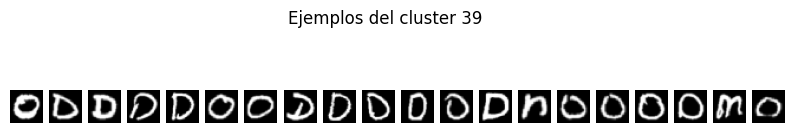

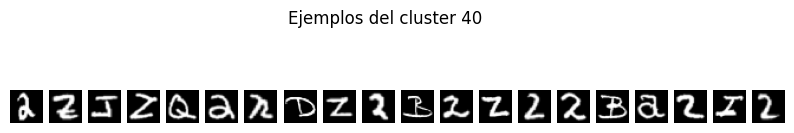

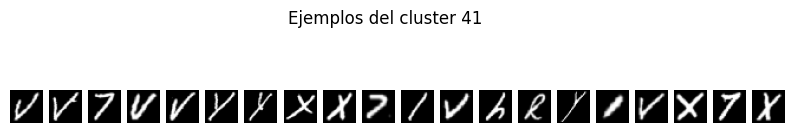

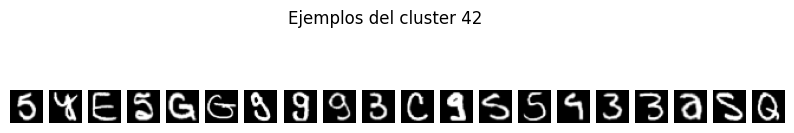

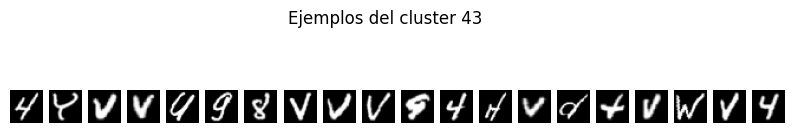

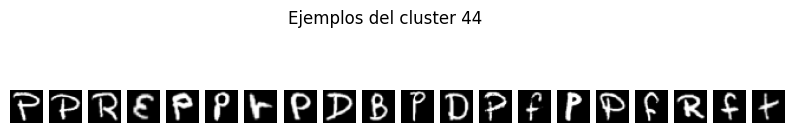

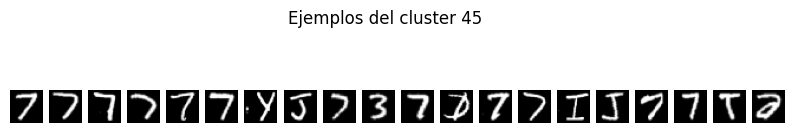

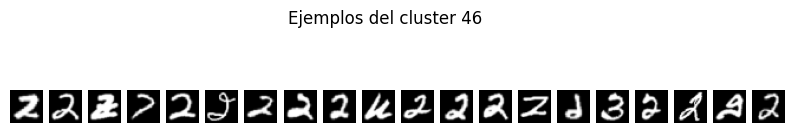

In [421]:
def show_examples_per_cluster(X, labels, cluster_id, n=20):
    idxs = np.where(labels == cluster_id)[0][:n]
    imgs = X[idxs].reshape(-1, 28, 28)
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(imgs):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Ejemplos del cluster {cluster_id}")
    plt.show()

for i in range(n_clases):
    show_examples_per_cluster(X, labels_km, i)

In [437]:
np.savez("embeddings_dataset.npz", X=Z, y=y, cluster=labels_km)
joblib.dump(kmeans, "kmeans_model.pkl")
autoencoder.save("autoencoder_model.h5")


In [455]:
cluster_to_label = {
    0: 'O', 1: 'v', 2: 'd', 3: 'l', 4: 'I', 5: 'L', 6: '3', 7: 'b', 8: 'D', 9: 'G',  
    10: 'g', 11: 'M', 12: 'L', 13: 'C', 14: '?', 15: 'O', 16: 'P', 17: 's', 18: 'r', 19: 'h',  
    20: 'V', 21: '6', 22: 'A', 23: 'H', 24: '8', 25: 'g',  
    26: 'G', 27: 'u', 28: 'W', 29: 'E', 30: 'E', 31: 'd', 32: 'H', 33: '7', 34: 'e', 35: 's',  
    36: 'T', 37: 'O', 38: 'X', 39: 'A', 40: 'M', 41: 'f', 42: 'S', 43: 'H', 44: 'a', 45: 'A',    
    46: 'h', 47: 'e'
}
cluster_to_label = {int(k): v for k, v in cluster_to_label.items()}

with open("cluster_labels.json", "w") as f:
    json.dump(cluster_to_label, f)


In [439]:
def extract_characters_from_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if 10 < w < 100 and 10 < h < 100:
            boxes.append((x, y, w, h))

    boxes = sorted(boxes, key=lambda b: (b[1] // 30, b[0]))

    chars = []
    for (x, y, w, h) in boxes:
        char = thresh[y:y+h, x:x+w]

        # Centrar en canvas 28x28
        canvas = np.zeros((28, 28), dtype=np.uint8)
        char = cv2.resize(char, (min(w, 20), min(h, 20)))
        cx, cy = char.shape[1] // 2, char.shape[0] // 2
        x_offset = (28 // 2) - cx
        y_offset = (28 // 2) - cy
        canvas[y_offset:y_offset+char.shape[0], x_offset:x_offset+char.shape[1]] = char

        chars.append(canvas)
    
    return chars

In [440]:
def predict_char(img28):
    img = img28.astype('float32') / 255.0
    img = img.T.flatten().reshape(1, -1)
    embedding = encoder.predict(img)
    cluster = kmeans.predict(embedding)[0]

    if cluster == 29:
        return ''  # omitirlo completamente
    return cluster_to_label.get(str(cluster), '?')

In [441]:
def recognize_text_from_image(image_path):
    chars = extract_characters_from_image(image_path)
    predictions = [predict_char(c) for c in chars]
    return "".join(predictions)

In [442]:
def show_segmented_characters(image_path):
    chars = extract_characters_from_image(image_path)
    plt.figure(figsize=(20, 3))
    for i, char in enumerate(chars):
        plt.subplot(1, len(chars), i+1)
        plt.imshow(char, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Caracteres segmentados de {os.path.basename(image_path)}")
    plt.show()

In [443]:
def debug_character_detection(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title("Escalada")
    plt.axis('off')
    plt.show()

    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    debug = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        if 5 < w < 100 and 5 < h < 100:
            cv2.rectangle(debug, (x, y), (x+w, y+h), (0,255,0), 1)

    plt.figure(figsize=(12, 6))
    plt.imshow(debug)
    plt.title(f"Contornos detectados en {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()


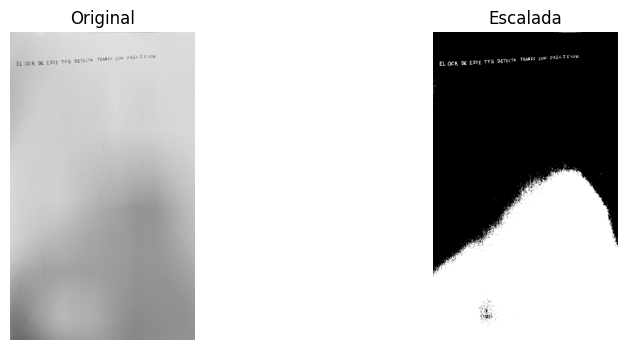

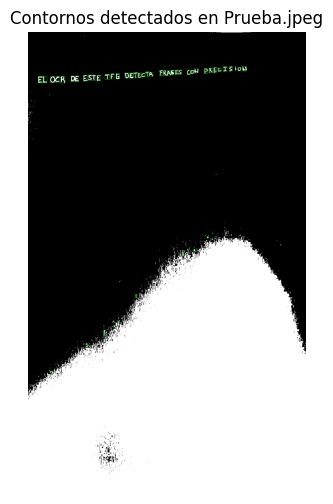

In [444]:
debug_character_detection("imagen/Prueba.jpeg")


In [445]:
def sort_boxes_linewise(boxes, line_tol_factor=0.7):
    if not boxes:
        return []

    boxes = sorted(boxes, key=lambda b: b[1])
    lines = []
    current_line = []
    _, y0, _, h0 = boxes[0]
    current_line.append(boxes[0])
    avg_height = h0

    for box in boxes[1:]:
        _, y, _, h = box
        if abs(y - y0) < line_tol_factor * avg_height:
            current_line.append(box)
        else:
            lines.append(sorted(current_line, key=lambda b: b[0]))
            current_line = [box]
            y0 = y
            avg_height = h

    lines.append(sorted(current_line, key=lambda b: b[0]))
    return [box for line in lines for box in line]

In [446]:
def segment_characters_from_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        if area < 150:
            continue
        aspect_ratio = w / h
        if aspect_ratio < 0.2 or aspect_ratio > 2.5:
            continue
        boxes.append((x, y, w, h))

    boxes = sort_boxes_linewise(boxes)

    chars = []
    for x, y, w, h in boxes:
        char = thresh[y:y+h, x:x+w]

        canvas = np.zeros((28, 28), dtype=np.uint8)
        char = cv2.resize(char, (min(w, 20), min(h, 20)))
        cx, cy = char.shape[1] // 2, char.shape[0] // 2
        x_offset = (28 // 2) - cx
        y_offset = (28 // 2) - cy
        canvas[y_offset:y_offset+char.shape[0], x_offset:x_offset+char.shape[1]] = char

        canvas = canvas.astype('float32') / 255.0
        canvas = np.transpose(canvas)
        chars.append(canvas.flatten())
    
    return np.array(chars), boxes


In [447]:
def predict_text_from_image(image_path, encoder, kmeans, cluster_to_label, space_threshold=20):
    chars, boxes = segment_characters_from_image(image_path)

    if len(chars) == 0:
        return ''

    embeddings = encoder.predict(chars)
    clusters = kmeans.predict(embeddings)
    letters = [cluster_to_label.get(c, '?') for c in clusters]

    # Insertar espacios según distancia entre cajas
    result = [letters[0]]
    for i in range(1, len(letters)):
        x_prev, _, w_prev, _ = boxes[i - 1]
        x_curr, _, _, _ = boxes[i]
        gap = x_curr - (x_prev + w_prev)
        if gap > space_threshold:
            result.append(' ')
        result.append(letters[i])

    return ''.join(result)


In [448]:
print(cluster_to_label.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])


In [456]:
image_path = "imagen/Moo.jpeg"
texto = predict_text_from_image(image_path, encoder, kmeans, cluster_to_label)
print("Texto detectado:\n", texto)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Texto detectado:
 LH hOAe A gOE MOOh


In [453]:
def debug_prediction_by_char(image_path):
    chars = extract_characters_from_image(image_path)
    for i, char in enumerate(chars):
        plt.imshow(char, cmap='gray')
        plt.title(f"Char {i}")
        plt.axis('off')
        plt.show()

        img = char.astype('float32') / 255.0
        img = np.transpose(img).flatten().reshape(1, -1)
        embedding = encoder.predict(img)
        cluster = kmeans.predict(embedding)[0]
        print(f"→ Cluster: {cluster} → Letra: {cluster_to_label.get(cluster, '?')}")

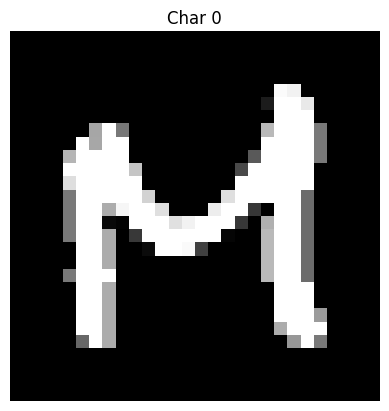

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
→ Cluster: 40 → Letra: M


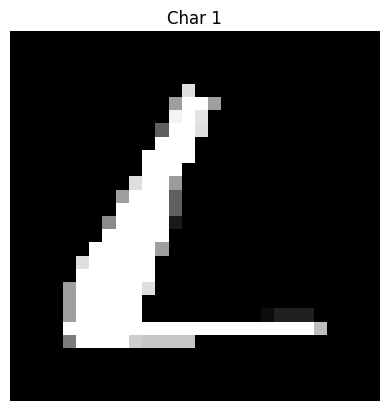

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
→ Cluster: 12 → Letra: L


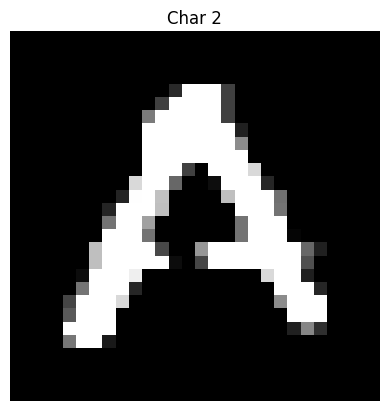

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
→ Cluster: 32 → Letra: H


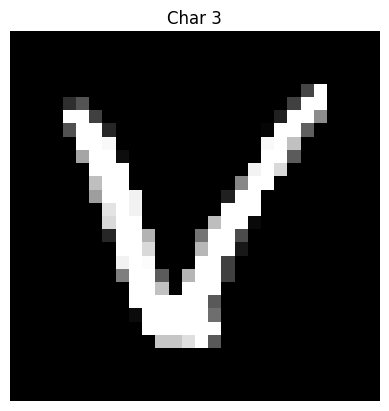

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
→ Cluster: 46 → Letra: h


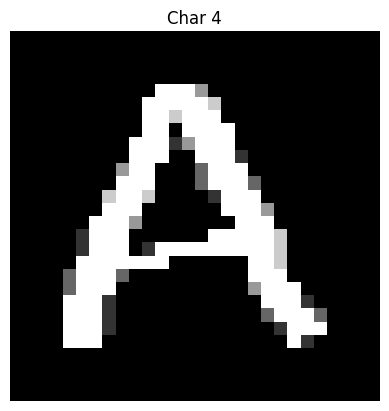

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
→ Cluster: 15 → Letra: O


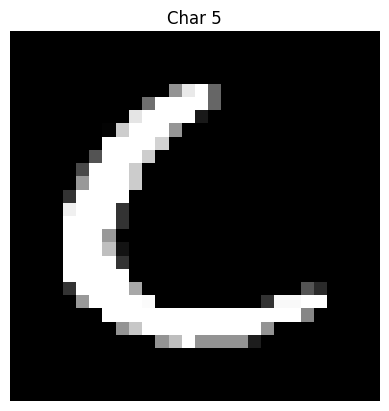

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
→ Cluster: 39 → Letra: A


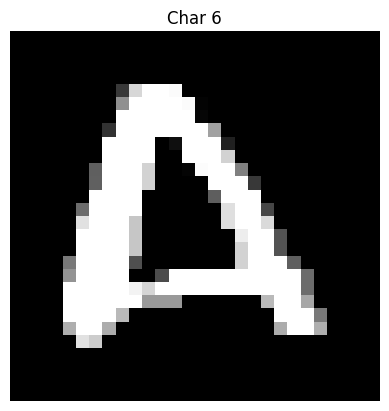

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
→ Cluster: 34 → Letra: e


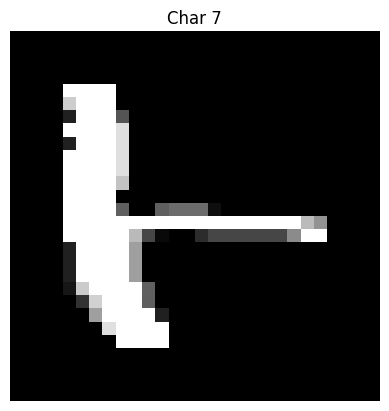

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
→ Cluster: 45 → Letra: A


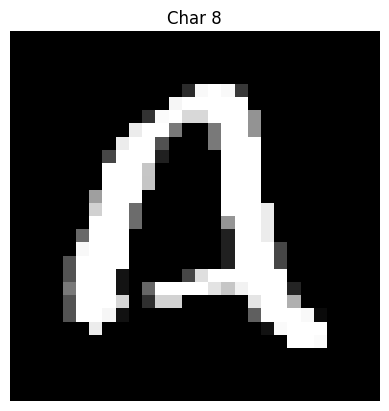

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
→ Cluster: 10 → Letra: g


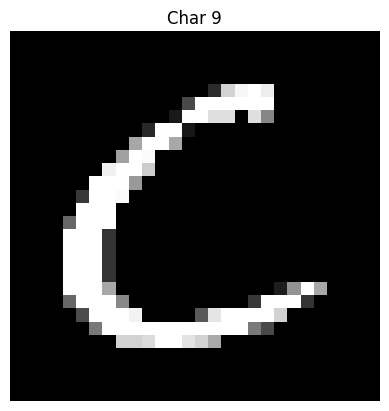

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
→ Cluster: 0 → Letra: O


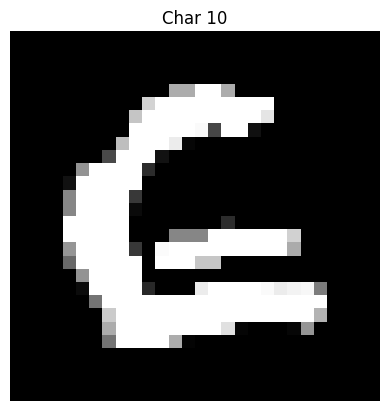

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
→ Cluster: 29 → Letra: E


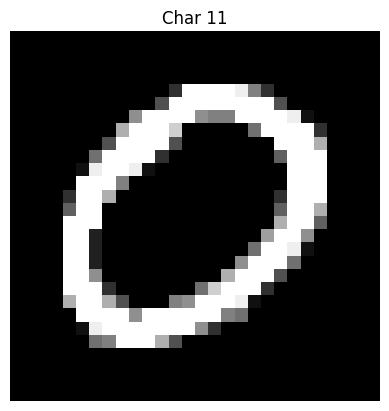

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
→ Cluster: 0 → Letra: O


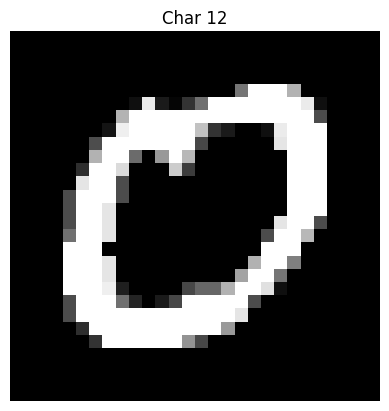

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
→ Cluster: 0 → Letra: O


In [457]:
debug_prediction_by_char(image_path)